neural_network

# Custom Feedforward Network

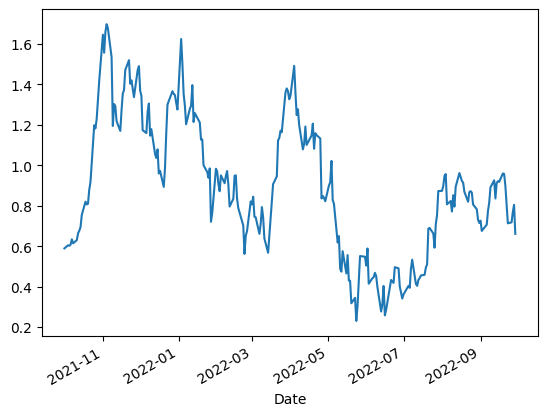

In [3]:
from pandas import read_csv
from datetime import datetime
from pandas.plotting import autocorrelation_plot
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, LSTM
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# Ensure eager execution
tf.config.run_functions_eagerly(True)

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

def parser(x):
	return datetime.strptime(x,'%Y-%m-%d')
 
series = read_csv('data/cleaned_data_vader.csv', header=0, parse_dates=[0], index_col=0)
# Filter rows where "Stock Name" is 'TLSA'
series = series[series['Stock Name'] == 'TSLA']
series = series.drop(['Stock Name', 'Adj Close'], axis=1)
series["Close"].plot()
plt.show()

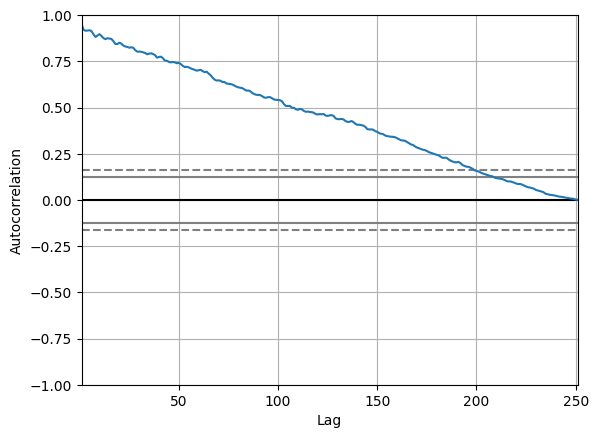

In [4]:
autocorrelation_plot(series)
plt.show()

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.0391
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.6689
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.3966
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.1549
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.0121
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9376
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7555
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6487
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5378
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5764
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3744
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3411
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3265
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2381
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2337
Epoch 16/100
7/7 ━━

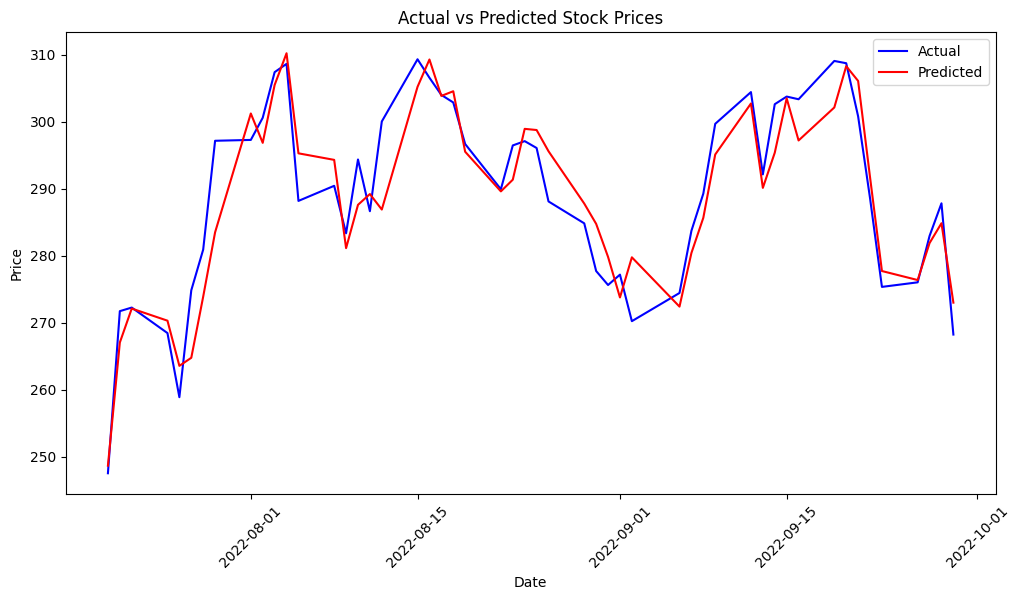

Mean Squared Error: 25.276901882011153


In [7]:
# Define the target variable (y) and the features (X)
y = series['Close']
X = series.drop('Close', axis=1)

# Split into train and test (80% train, 20% test)
train_size = int(len(series) * 0.8)  # 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Scale the features (X) using StandardScaler
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale the target variable (y) using StandardScaler
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))  # Reshape for compatibility
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Define the model
model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=X_train_scaled.shape[1]))  # Fewer units
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32)

# Predict on the test data (predictions are scaled)
forecast_scaled = model.predict(X_test_scaled)

# Reshape forecast to 1D
forecast_scaled = forecast_scaled.reshape(-1)

# Inverse transform the forecast to get original scale values
forecast = scaler_y.inverse_transform(forecast_scaled.reshape(-1, 1))

# Convert y_test to numpy for consistency with forecast
y_test_dates = y_test.index.to_numpy()

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_dates, y_test.values, label='Actual', color='blue')  # Actual values
plt.plot(y_test_dates, forecast, label='Predicted', color='red')  # Predicted values
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for readability
plt.show()

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, forecast)
print(f'Mean Squared Error: {mse}')


# CNN + LSTM

In [6]:
# Load data
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')

series = read_csv('data/stock_yfinance_data.csv', header=0, parse_dates=[0], index_col=0)
# Filter rows where "Stock Name" is 'TLSA'
series = series[series['Stock Name'] == 'TSLA']
series = series.drop(['Stock Name', 'Adj Close'], axis=1)

# Scale only the 'Close' price
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(series[['Close']].values)  # Scale only the 'Close' price

# Function to create data sequences for time-series forecasting
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back, 0])  # Use only 'Close' price
        y.append(data[i + look_back, 0])  # Predict the next 'Close' price
    return np.array(X), np.array(y)

# Prepare the data
look_back = 60
X, y = create_dataset(scaled, look_back)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape for CNN (samples, time steps, features)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build the CNN + LSTM hybrid model
model = Sequential()

# CNN layers for feature extraction
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))

# LSTM layer for capturing temporal dependencies
model.add(LSTM(50, activation='relu'))

# Fully connected layer to output the predicted stock price
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=2)

# Evaluate the model
mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Squared Error on Test Set: {mse}")

# Predict
y_pred = model.predict(X_test)

# Rescale predictions back to original scale using the same scaler
y_pred_rescaled = scaler.inverse_transform(y_pred)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

# Plot the results
import matplotlib.pyplot as plt
plt.plot(y_test_rescaled, label='True Stock Price')
plt.plot(y_pred_rescaled, label='Predicted Stock Price')
plt.title('Stock Price Prediction with CNN + LSTM')
plt.legend()
plt.show()


Epoch 1/20
5/5 - 1s - 155ms/step - loss: 0.2207 - val_loss: 0.1267
Epoch 2/20
5/5 - 1s - 120ms/step - loss: 0.1331 - val_loss: 0.0692
Epoch 3/20
5/5 - 1s - 119ms/step - loss: 0.0664 - val_loss: 0.0214
Epoch 4/20
5/5 - 1s - 123ms/step - loss: 0.0262 - val_loss: 0.0048
Epoch 5/20
5/5 - 1s - 120ms/step - loss: 0.0335 - val_loss: 0.0043
Epoch 6/20
5/5 - 1s - 121ms/step - loss: 0.0217 - val_loss: 0.0080
Epoch 7/20
5/5 - 1s - 119ms/step - loss: 0.0229 - val_loss: 0.0098
Epoch 8/20
5/5 - 1s - 120ms/step - loss: 0.0217 - val_loss: 0.0063
Epoch 9/20
5/5 - 1s - 120ms/step - loss: 0.0186 - val_loss: 0.0041
Epoch 10/20
5/5 - 1s - 122ms/step - loss: 0.0181 - val_loss: 0.0038
Epoch 11/20
5/5 - 1s - 119ms/step - loss: 0.0171 - val_loss: 0.0042
Epoch 12/20
5/5 - 1s - 120ms/step - loss: 0.0163 - val_loss: 0.0043
Epoch 13/20
5/5 - 1s - 121ms/step - loss: 0.0153 - val_loss: 0.0037
Epoch 14/20
5/5 - 1s - 122ms/step - loss: 0.0145 - val_loss: 0.0036
Epoch 15/20
5/5 - 1s - 119ms/step - loss: 0.0139 - val_lo

KeyboardInterrupt: 

# LSTM using sequences

Epoch 1/20


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step - loss: 0.1674 - val_loss: 0.0064
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 425ms/step - loss: 0.0412 - val_loss: 0.0081
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 424ms/step - loss: 0.0245 - val_loss: 0.0088
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 491ms/step - loss: 0.0285 - val_loss: 0.0082
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - loss: 0.0233 - val_loss: 0.0041
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - loss: 0.0192 - val_loss: 0.0067
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - loss: 0.0180 - val_loss: 0.0044
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step - loss: 0.0175 - val_loss: 0.0044
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 435ms/step - loss: 0.0173 - val_loss: 0.0042
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 427ms/step - loss: 0.0168 - val_loss: 0.0048
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 426ms/step - loss: 0.0142 - val_loss: 0.0045
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 420ms/step - loss: 0.0146 - val_loss: 0.0040


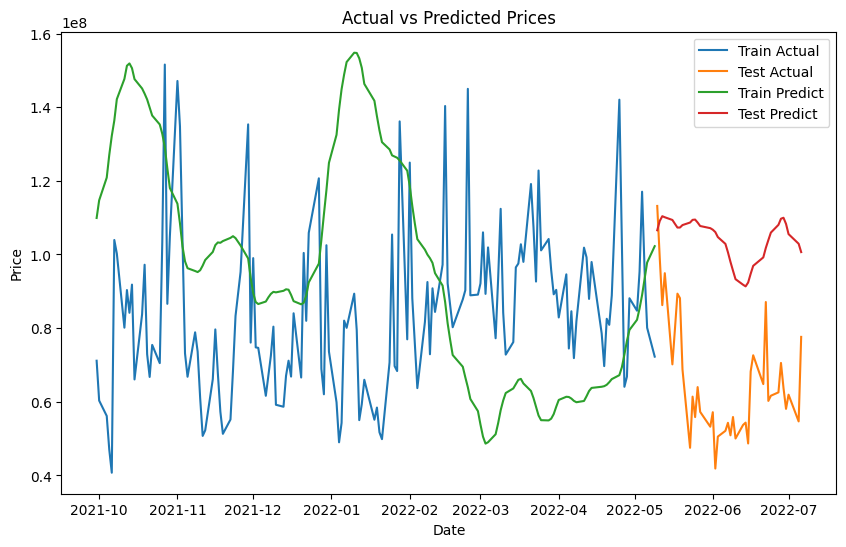

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assuming 'series' is your DataFrame containing stock data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(series)
scaled_data = pd.DataFrame(scaled_data, columns=series.columns)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X_sequence = data.iloc[i:i+seq_length].values  # Use NumPy array directly
        X.append(X_sequence)
        y.append(data.iloc[i + seq_length]['Close'])  # Target is 'Close' price after the sequence
    return np.array(X), np.array(y)  # Return as NumPy arrays

# Hyperparameters
seq_length = 60  # Number of time steps (days) to look back

# Create sequences
X, y = create_sequences(scaled_data, seq_length)

# Reshape X for LSTM (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))  # Shape: (samples, time steps, features)

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Reverse scaling for predictions
train_predict = train_predict.reshape(-1, 1)  # Reshape to 2D (samples, 1 feature)
test_predict = test_predict.reshape(-1, 1)    # Reshape to 2D (samples, 1 feature)

# Reverse scaling for predictions (only on 'Close' column)
train_predict_full = np.copy(scaled_data.iloc[seq_length:len(train_predict)+seq_length, :])
train_predict_full[:, -1] = train_predict.reshape(-1)

test_predict_full = np.copy(scaled_data.iloc[len(train_predict)+seq_length:, :])
test_predict_full[:, -1] = test_predict.reshape(-1)

train_predict = scaler.inverse_transform(train_predict_full)[:, -1].reshape(-1, 1)
test_predict = scaler.inverse_transform(test_predict_full)[:, -1].reshape(-1, 1)

# Reverse scaling for actual values
y_train_actual = scaler.inverse_transform(scaled_data.iloc[seq_length:len(train_predict)+seq_length, :])[:, -1].reshape(-1, 1)
y_test_actual = scaler.inverse_transform(scaled_data.iloc[len(train_predict)+seq_length:, :])[:, -1].reshape(-1, 1)

train_mse = mean_squared_error(y_train_actual, train_predict)
test_mse = mean_squared_error(y_test_actual, test_predict)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.plot(series.index[:len(y_train_actual)], y_train_actual, label='Train Actual')
plt.plot(series.index[len(y_train_actual):len(y_train_actual) + len(y_test_actual)], y_test_actual, label='Test Actual')
plt.plot(series.index[:len(train_predict)], train_predict, label='Train Predict')
plt.plot(series.index[len(train_predict):len(train_predict) + len(test_predict)], test_predict, label='Test Predict')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
